# Spotify Insights
note: The value of streams is NULL when the chart column is "viral50".

1. Carga de um conjunto de dados com um volume de dados adequado para o contexto da
disciplina (+1000 registros);
2. Realização do pré-processamento sobre o conjunto de dados;
3. A partir do conjunto resultante (pré-processado), estatísticas e visualizações devem ser
geradas para promover um entendimento inicial dos dados;
4. Com o conjunto de dados do item 3 aplique algum algoritmo de aprendizado de máquina,
apresente e discuta os resultados obtidos. Talvez seja necessário realizar transformações
para que os dados se adequem ao algoritmo escolhido.
A partir disso, cada equipe deve realizar uma apresentação discutindo todos os itens da
implementação (descrição e carga do conjunto de dados, pré-processamento realizado,
estatísticas e visualizações e, por fim, utilização de um algoritmo de aprendizado de máquina
com apresentação dos resultados).

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pandas as pd
import time


In [2]:
# Cria o DataFrame em chunks de tamanho 100000
df = pd.read_csv("charts.csv", chunksize=100000)

In [3]:
a = pd.concat(df, ignore_index=True)
a.head(20)

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0


In [4]:
spotify_data = a
spotify_data.shape

(26173514, 9)

In [5]:
start_date = '2020-04-01'
end_date = '2020-04-30'
mask = a['date'].between(start_date, end_date)
a = a.loc[mask]
a.shape

(461050, 9)

In [26]:
import re
a = a.replace(re.compile(r'[^\w\s]+'), '', regex=True)
a['trend'] = a['trend'].replace('MOVE_DOWN', 0)
a['trend'] = a['trend'].replace('MOVE_UP', 1)
a['trend'] = a['trend'].replace('SAME_POSITION', 2)
a['trend'] = a['trend'].replace('NEW_ENTRY', 3)

missing = a.isna()
a = a.dropna()

condition = (a['region'] == 'Brazil')
brazil = a.loc[condition]
brazil = brazil.loc[brazil['artist'] == 'Gusttavo Lima']
brazil = brazil.sort_values(by=['rank'] , ascending=True)
brazil.head(5)

,title,rank,date,artist,url,region,chart,trend,streams
10069709,A Gente Fez Amor Ao Vivo,1,20200415,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,586257.0
9288821,A Gente Fez Amor Ao Vivo,1,20200406,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,574852.0
9182856,A Gente Fez Amor Ao Vivo,1,20200405,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,662527.0
11231858,A Gente Fez Amor Ao Vivo,1,20200427,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,535342.0
9483911,A Gente Fez Amor Ao Vivo,1,20200408,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,1,585756.0


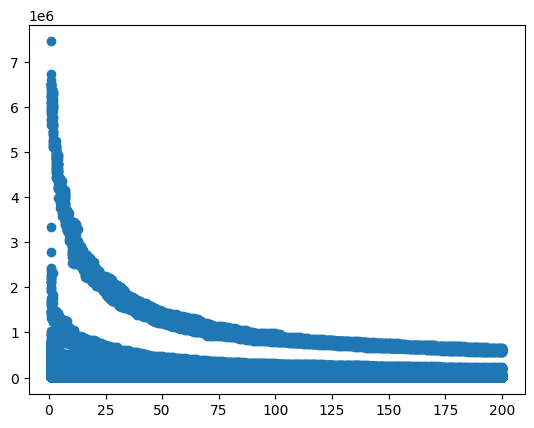

In [27]:
import matplotlib.pyplot as plt

y = a['streams']
X = a['rank']

plt.scatter(X, y)
plt.show()

/tmp/ipykernel_12798/3975251512.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'date', y = 'rank', data=brazil, hue='title', ci=None).set_title('Trends in Top 200')


Text(0.5, 1.0, 'Trends in Top 200')

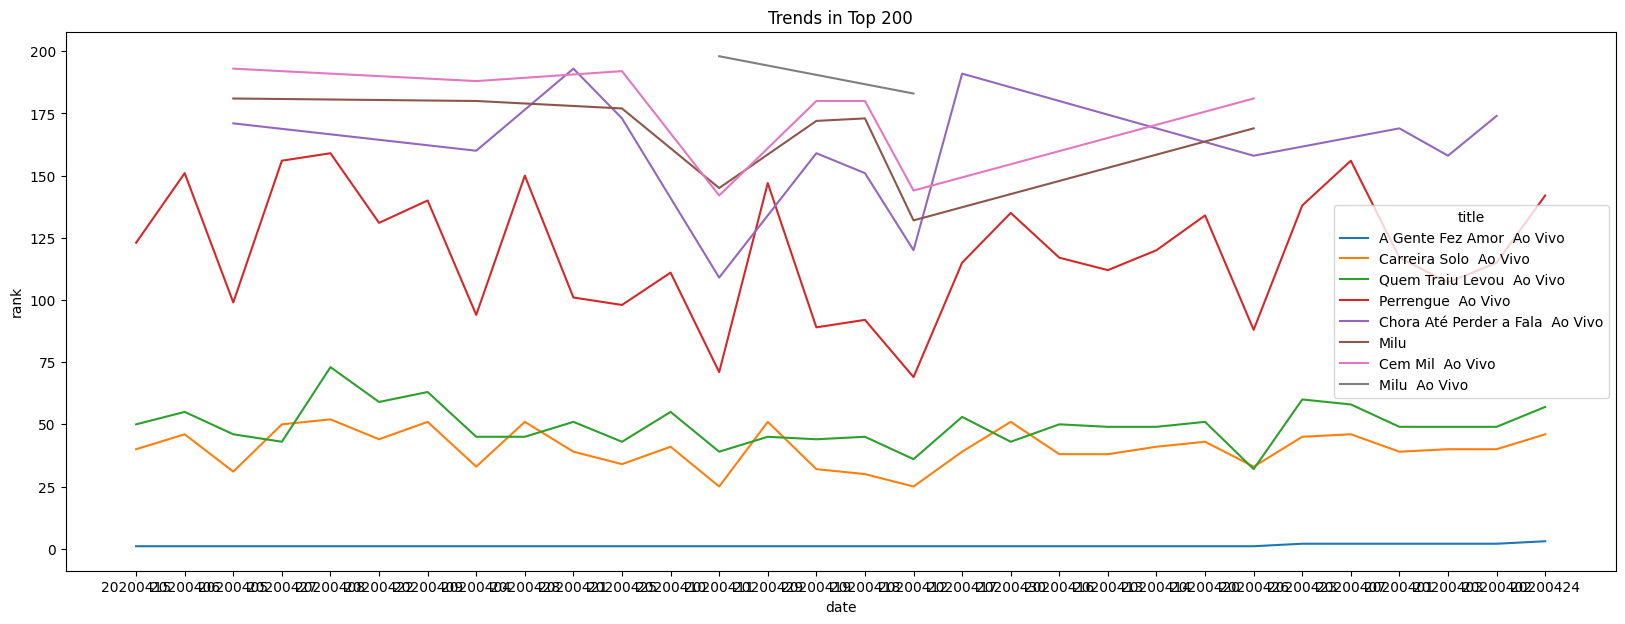

In [28]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x = 'date', y = 'rank', data=brazil, hue='title', ci=None).set_title('Trends in Top 200')

/tmp/ipykernel_12798/2338458900.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'date', y = 'rank', data=brazil, hue='title', ci=None).set_title('Trends in Top 200')


Text(0.5, 1.0, 'Trends in Top 200')

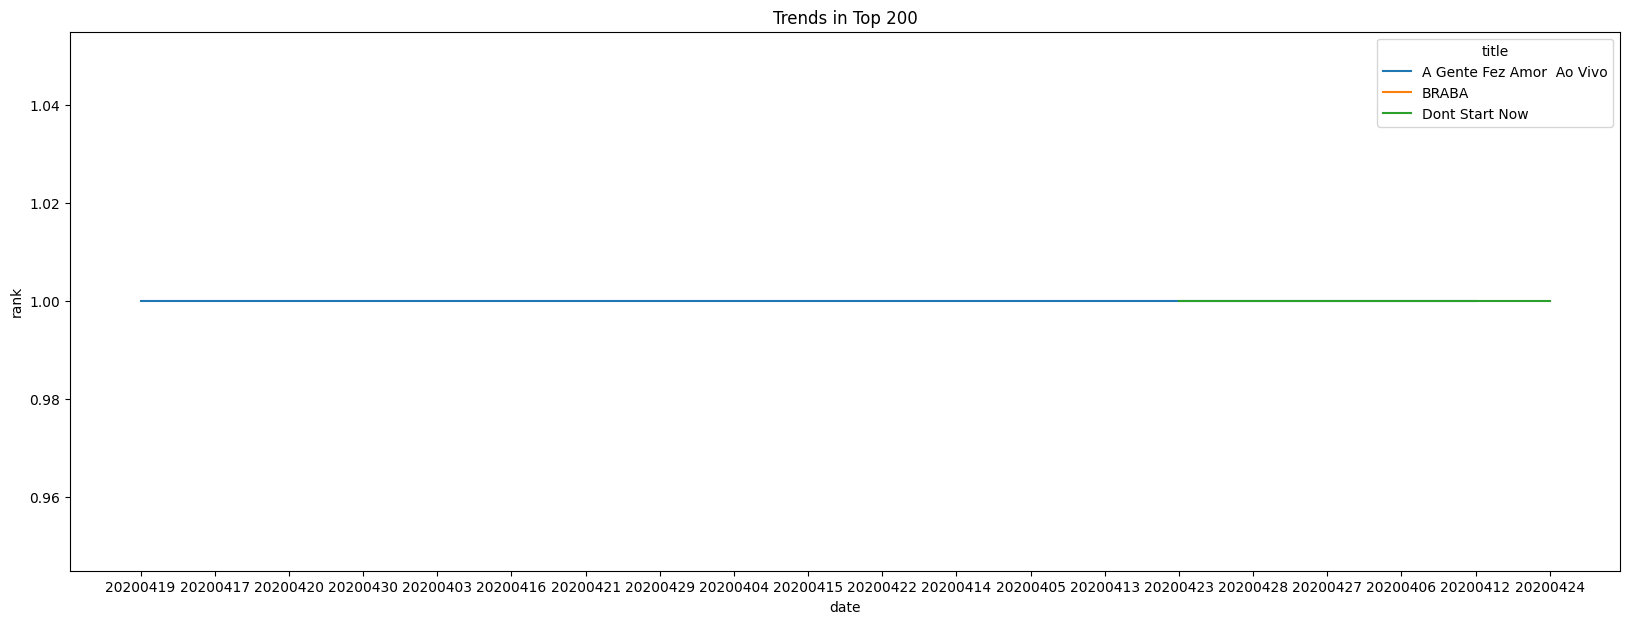

In [17]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x = 'date', y = 'rank', data=brazil, hue='title', ci=None).set_title('Trends in Top 200')

In [14]:
predicted = regr.predict([[100000, 1]])

print(predicted)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
a['streams'].sort_values(ascending=False)

### Word Cloud

In [ ]:
spotify_data = spotify_data.filter(items=['streams'])
spotify_data.shape

In [ ]:

import matplotlib.pyplot as plt

from wordcloud import WordCloud

def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white',
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

counts = spotify_data['region'].value_counts()

visualize_word_counts(counts)

### 


In [ ]:
# most streamed song in brazil 3D scatter(x, y, z) chart
from numpy import nan

datachart = df.filter(df.region == 'Brazil').groupBy('title', 'date').sum('streams').sort(f.col('sum(streams)').desc()).toPandas()
datachart['title'] = datachart['title'].replace('INTERE$$EIRA', 'interesseira')
datachart['sum(streams)'] = datachart['sum(streams)'].replace(nan, None)
datachart = datachart.dropna()

datachart

In [ ]:
# plt.scatter(x='title', y='sum(streams)', data= datachart)

In [ ]:
# from numpy import nan
# from plotly.offline import iplot
# import plotly.graph_objs as go
# import plotly.express as px

# datachart = df.filter(df.region == 'Brazil').groupBy('title', 'date').sum('streams').sort(f.col('sum(streams)').desc()).toPandas()
# datachart['title'] = datachart['title'].replace('INTERE$$EIRA', 'interesseira')
# datachart['sum(streams)'] = datachart['sum(streams)'].replace(nan, None)
# datachart = datachart.dropna()

# fig = px.scatter_3d(datachart, x='title', y='date', z='sum(streams)')
# fig.show()


### Algoritmo de classificação